<a href="https://colab.research.google.com/github/utkarshp1161/pyroVED/blob/main/examples/VAE_gp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#VAE with GP


---



---



Prepared by Utkarsh Pratiush

E-mail: utkarshp1161@gmail.com

In [1]:
#@title Installation
# Install the latest version from source
# (or you may instal a stable version from PyPi instead with !pip install pyroved)
!pip install -q git+https://github.com/ziatdinovmax/pyroved.git
# install Kornia library (for image transformations)
!pip install -q kornia

^C


In [1]:
#@title Imports
from typing import Tuple

import pyroved as pv
import torch
import kornia as K
from torchvision import datasets
import matplotlib.pyplot as plt
import seaborn as sns

tt = torch.tensor

In [2]:
#@title Helper functions
def rotate_images(imgdata, rotation_range: Tuple[int]) -> Tuple[torch.Tensor]:
    torch.manual_seed(0)
    theta = torch.randint(*rotation_range, size=(len(imgdata),))
    imgdata = K.geometry.rotate(imgdata.float()[:, None], theta.float())
    imgdata = imgdata / imgdata.max()
    return imgdata, theta


def get_mnist_data(rotation_range: Tuple[int]) -> Tuple[torch.Tensor]:
    !wget -qq www.di.ens.fr/~lelarge/MNIST.tar.gz
    !tar -zxf MNIST.tar.gz
    mnist_trainset = datasets.MNIST(
        root='.', train=True, download=False, transform=None)
    images_r, theta = rotate_images(mnist_trainset.data, rotation_range)
    return images_r, pv.utils.to_onehot(mnist_trainset.targets, 10), theta

Get training data and create a dataloader object:

In [4]:
train_data, train_labels, angles = get_mnist_data(rotation_range=[-60, 61])
train_data = train_data[-10000:]
train_labels = train_labels[-10000:]
angles = angles[-10000:]
train_loader = pv.utils.init_dataloader(train_data, batch_size=200)

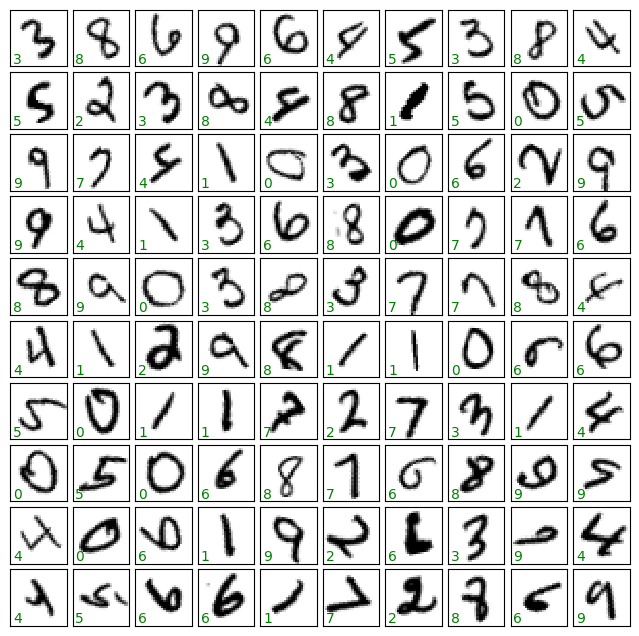

In [5]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, im, lbl in zip(axes.flat, train_data, train_labels):
    ax.imshow(im.squeeze(), cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(lbl.argmax().item()),
            transform=ax.transAxes, color='green')

First, we explore the simple VAE:

In [6]:
in_dim = (28, 28)

vae = pv.models.iVAE(in_dim, latent_dim=2, invariances=None, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)
# Train for n epochs:
for e in range(100):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 307.0151
Epoch: 2 Training loss: 217.5042
Epoch: 3 Training loss: 213.4215
Epoch: 4 Training loss: 209.2862
Epoch: 5 Training loss: 203.7678
Epoch: 6 Training loss: 197.9216
Epoch: 7 Training loss: 195.4105
Epoch: 8 Training loss: 193.8121
Epoch: 9 Training loss: 192.4836
Epoch: 10 Training loss: 191.2418
Epoch: 11 Training loss: 190.2216
Epoch: 12 Training loss: 189.1047
Epoch: 13 Training loss: 188.1140
Epoch: 14 Training loss: 187.1432
Epoch: 15 Training loss: 186.2500
Epoch: 16 Training loss: 185.4216
Epoch: 17 Training loss: 184.6073
Epoch: 18 Training loss: 183.9414
Epoch: 19 Training loss: 183.3360
Epoch: 20 Training loss: 182.6716
Epoch: 21 Training loss: 182.2362
Epoch: 22 Training loss: 181.6895
Epoch: 23 Training loss: 181.3055
Epoch: 24 Training loss: 180.8058
Epoch: 25 Training loss: 180.3297
Epoch: 26 Training loss: 179.9288
Epoch: 27 Training loss: 179.4735
Epoch: 28 Training loss: 179.1626
Epoch: 29 Training loss: 178.7776
Epoch: 30 Training loss

Visualize the learned latent manifold:

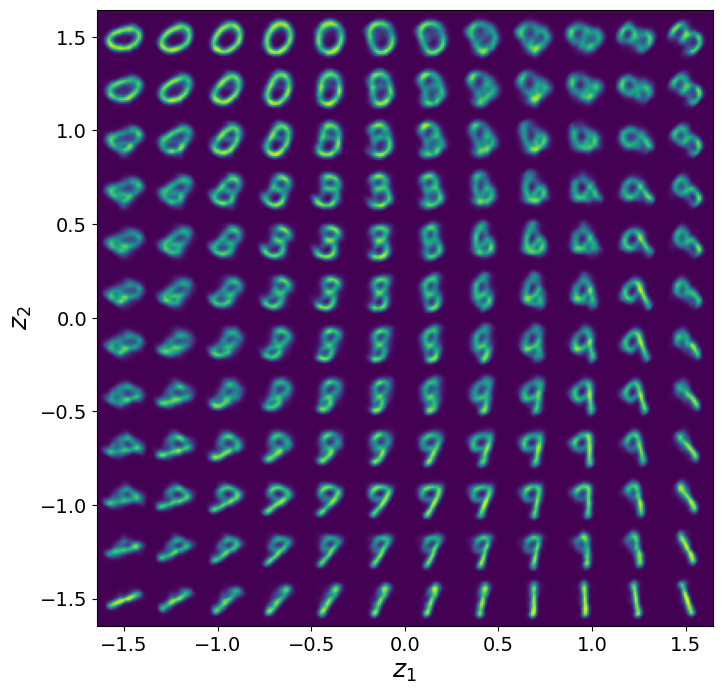

In [7]:
vae.manifold2d(d=12, cmap='viridis');

Encode all the data and view the encoded values as a scatter plot:

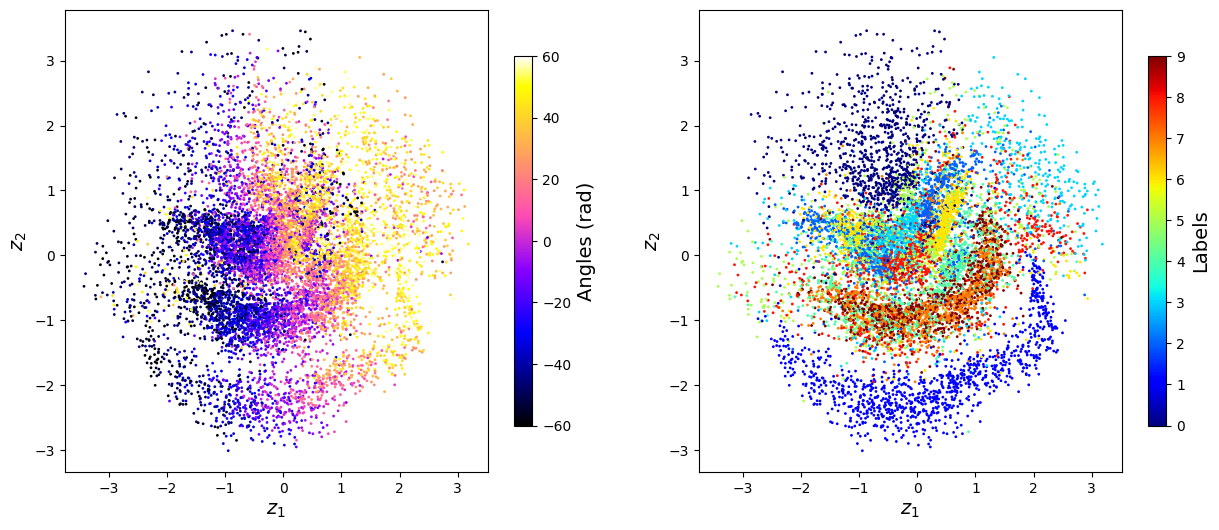

In [8]:
z_mean, z_sd = vae.encode(train_data)
_, labels = torch.max(train_labels, 1)
labels = labels.cpu().tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(15, 6))
im1 = ax1.scatter(z_mean[:,-1], z_mean[:,-2], c=angles, s=1, cmap='gnuplot2')
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("Angles (rad)", fontsize=14)
cbar1.ax.tick_params(labelsize=10)
im2 = ax2.scatter(z_mean[:,-1], z_mean[:,-2], c=labels, s=1, cmap='jet')
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("Labels", fontsize=14)
cbar2.ax.tick_params(labelsize=10);

# GP on VAE

In [9]:
import numpy as np

def one_hot_to_numbers(one_hot_labels):
    """
    Converts one-hot encoded labels to their numeric form.

    Args:
    one_hot_labels (numpy.ndarray): A 2D array of one-hot encoded labels.

    Returns:
    numpy.ndarray: An array of numeric labels.
    """
    return np.argmax(one_hot_labels, axis=1)

In [10]:
gp_labels = one_hot_to_numbers(train_labels.cpu().numpy())
gp_iterations = 1
d =12

/lustre/isaac/scratch/upratius/projects/pyroVED/pyroved/models/ivae.py:322: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(train_data, dtype=torch.float32)


Training GP model...


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.07s/it]
/lustre/isaac/scratch/upratius/projects/pyroVED/pyroved/models/ivae.py:338: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z, dtype=torch.float32)


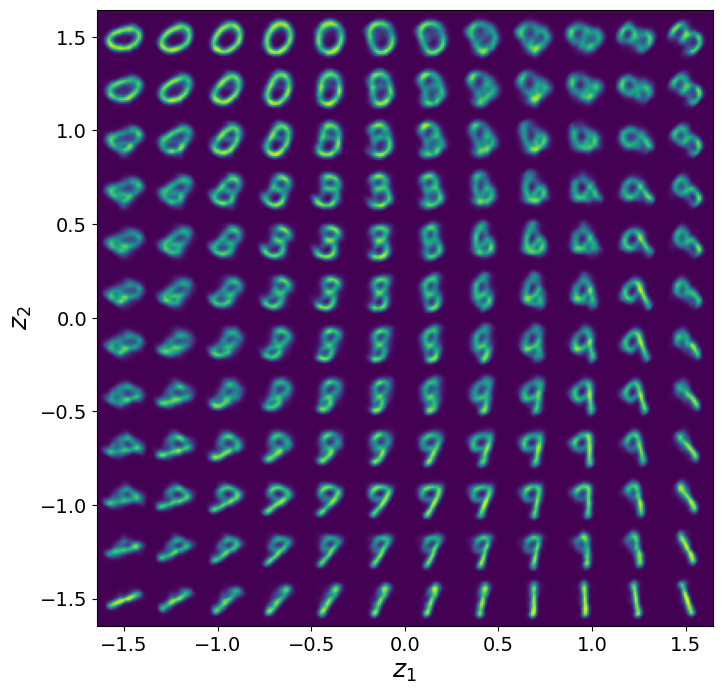

<Figure size 800x800 with 0 Axes>

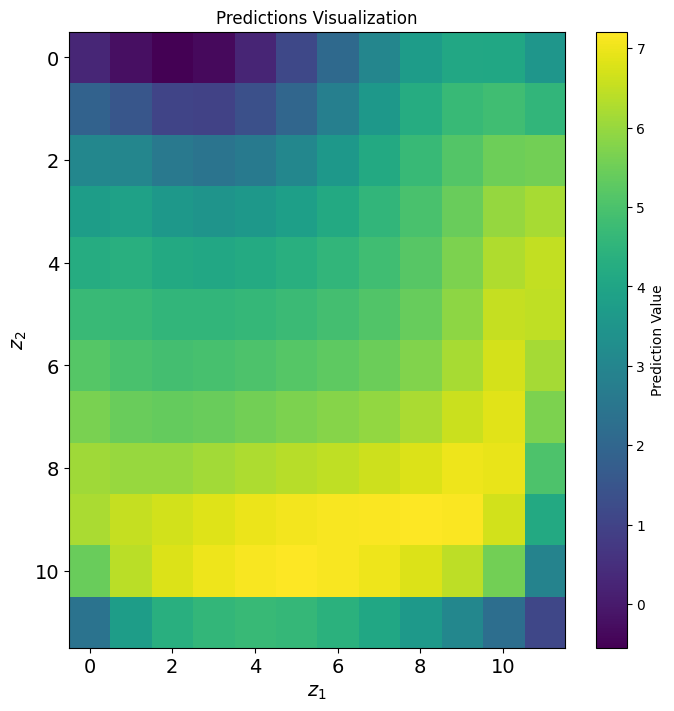

In [11]:
vae.predict_on_latent(train_data = train_data, gp_labels = gp_labels, gp_iterations=1, d=12);